In [1]:
!pip install pymysql
!pip install pymssql

import LibData
import LibUtils
import LibML
import LibFile
import LibEE

import pandas as pd
import numpy as np

# jobName = '201216_Train_split1'

# x, y = LibData.GetXYBase(jobName)
# x = LibData.GetMoneyness(x)
# x = LibData.GetAttainedAge(x)
# x = LibData.GetIrReduction(x)
# x = LibEE.GetX_Inter_EM_AA_old(x)
# x = LibEE.GetXEmbApplied(3, x, y, ['ProdCode', 'Inter_EM_AA'])
# scaler, x = LibUtils.ScaleStandard(x)

# x.to_csv('x.csv', index=False)
# y.to_csv('y.csv', index=False)

x = pd.read_csv('x.csv')
y = pd.read_csv('y.csv')


     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 1.3MB 4.2MB/s 


In [ ]:
# Lasso

from sklearn import linear_model

model_lasso = linear_model.Lasso(alpha=2.0)
model_lasso.fit(x, y['pv_claim'])

colList = pd.DataFrame({'colName' : x.columns, 'coef' : model_lasso.coef_})
selected = colList[abs(round(colList.coef,3)) > 0.0001]

mask = x.columns.isin(selected['colName'].to_numpy())
notSelected = x.columns[np.invert(mask)]

print(selected.colName.to_numpy())
print(notSelected.to_numpy())


['ElapsedMth' 'Sex' 'Prem' 'PremYr' 'AccumPrem' 'ContAmt' 'FundVal01'
 'FundVal02' 'FundVal03' 'FundAllo01' 'FundAllo03' 'IR12' 'IR14'
 'Moneyness' 'AttainedAge' 'ee_ProdCode_01' 'ee_ProdCode_02'
 'ee_Inter_EM_AA_00' 'ee_Inter_EM_AA_01' 'ee_Inter_EM_AA_02']
['StartAge' 'FundAllo02' 'IR06' 'IR09' 'ee_ProdCode_00']


In [ ]:
mask

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True])

In [15]:
def GetOrdered(model, topCnt):
    cols = pd.DataFrame({'colName' : x.columns, 'score': model.feature_importances_})
    ordered = cols.sort_values(by=['score'], ascending=False).reset_index(drop=True)
    ordered['rank'] = ordered.index + 1
    top = ordered[ordered['rank'] <= topCnt]
    return top

# 포함된, 포함되지 않은
def PrintSelectedAndNot(top20):
    selected = top20.colName.to_numpy()
    mask = x.columns.isin(selected)
    notSelected = x.columns[np.invert(mask)].to_numpy()
    print(selected)
    print(notSelected)



In [2]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 1000, max_features = 19, min_samples_leaf = 1)
model.fit(x, y['pv_claim'])


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=19, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

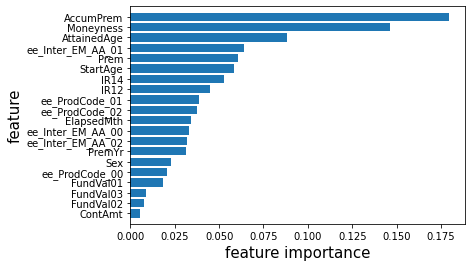

['AccumPrem' 'Moneyness' 'AttainedAge' 'ee_Inter_EM_AA_01' 'Prem'
 'StartAge' 'IR14' 'IR12' 'ee_ProdCode_01' 'ee_ProdCode_02' 'ElapsedMth'
 'ee_Inter_EM_AA_00' 'ee_Inter_EM_AA_02' 'PremYr' 'Sex' 'ee_ProdCode_00'
 'FundVal01' 'FundVal03' 'FundVal02' 'ContAmt']
['FundAllo01' 'FundAllo02' 'FundAllo03' 'IR06' 'IR09']


In [16]:
import matplotlib.pyplot as plt

n_feature = 20
index = np.arange(n_feature)
top20 = GetOrdered(model, n_feature)

plt.barh(index, top20['score'], align='center', )
plt.yticks(index, top20['colName'], )
plt.ylim(-1,20, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.gca().invert_yaxis()
plt.show()

PrintSelectedAndNot(top20)

In [3]:
# XGBoost

# XGBoost

from xgboost import XGBRegressor
model2 = XGBRegressor(max_delta_step=0.0, objective = 'reg:squarederror', nthread=-1,
                     n_estimators = 5000, colsample_bytree=0.9168,learning_rate=0.1284,max_depth=20,min_child_weight=5,subsample=0.4541)


model2.fit(x, y['pv_claim'])



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9168, gamma=0,
             importance_type='gain', learning_rate=0.1284, max_delta_step=0.0,
             max_depth=20, min_child_weight=5, missing=None, n_estimators=5000,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.4541, verbosity=1)

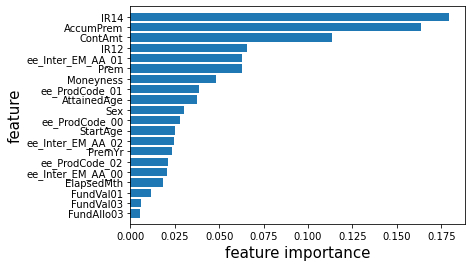

['IR14' 'AccumPrem' 'ContAmt' 'IR12' 'ee_Inter_EM_AA_01' 'Prem'
 'Moneyness' 'ee_ProdCode_01' 'AttainedAge' 'Sex' 'ee_ProdCode_00'
 'StartAge' 'ee_Inter_EM_AA_02' 'PremYr' 'ee_ProdCode_02'
 'ee_Inter_EM_AA_00' 'ElapsedMth' 'FundVal01' 'FundVal03' 'FundAllo03']
['FundVal02' 'FundAllo01' 'FundAllo02' 'IR06' 'IR09']


In [17]:
import matplotlib.pyplot as plt

n_feature = 20
index = np.arange(n_feature)
top20 = GetOrdered(model2, n_feature)

plt.barh(index, top20['score'], align='center', )
plt.yticks(index, top20['colName'], )
plt.ylim(-1,20, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.gca().invert_yaxis()
plt.show()

PrintSelectedAndNot(top20)